In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from utils import *

# torch._dynamo.config.suppress_errors = True

Load dataset:

In [2]:
data_size = 1_000_000
data_gen = PixelFeatureRandomRing(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=True, sigma=0.3, features_degree=3, seed=42, device='cpu', test_return=False)
data_gen.noise_delta

{'mse_loss': {'mean': 0.002878583036363125, 'std': 0.004131085239350796},
 'l1_loss': {'mean': 0.04067716374993324, 'std': 0.034985028207302094}}

In [3]:
features, transformed_features, imgs = data_gen.random_sample(256)
print(features)
print(transformed_features)

[[8.0000000e+00 8.0000000e+00 8.8920116e+00 1.1179569e+00 1.7011788e+00
  2.1987391e-01]
 [8.0000000e+00 1.5000000e+01 8.0376949e+00 1.1699002e+00 2.0508831e+00
  3.9855751e-01]
 [9.0000000e+00 1.2000000e+01 6.7146988e+00 1.0942107e+00 5.6096549e+00
  1.3342768e-02]
 ...
 [1.4000000e+01 1.5000000e+01 7.3358769e+00 1.1204083e+00 1.2330843e+00
  2.0871958e-01]
 [1.1000000e+01 8.0000000e+00 6.3055525e+00 9.2264098e-01 4.4202652e+00
  8.8033974e-02]
 [9.0000000e+00 9.0000000e+00 6.0702686e+00 1.1212680e+00 3.9266813e+00
  1.1191115e-01]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.22650460e-02
  5.24017162e-02 8.50378859e-02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 8.50024562e-02
  2.07573100e-01 5.06482435e-01]
 [0.00000000e+00 1.42857143e-01 5.71428571e-01 ... 2.12900609e-02
  6.36320893e-04 1.90033070e-05]
 ...
 [0.00000000e+00 8.57142857e-01 1.00000000e+00 ... 1.60919038e-02
  3.42268820e-02 7.27412852e-02]
 [0.00000000e+00 4.28571429e-01 0.00000000e+00 ... 8.721790

Test generator:

In [52]:
class OnePixel(nn.Module):
    def __init__(self, *args, **kwargs):
        super(OnePixel, self).__init__()
        
        self.linear_0 = nn.Linear(84, 42)
        self.linear_1 = nn.Linear(84, 42)

        self.linear_2 = BayesLinear(42, 42)

        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        kl_sum = 0

        x_0 = self.linear_0(x)
        x_1 = self.linear_1(x)

        x, kl = self.linear_2(x_0)
        x = x + x_1
        kl_sum += kl
        
        x = x.mean(dim=1).unsqueeze(-1)
        
        return x, kl_sum / 3

In [53]:
# load generator
generator = OnePixel()
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/PixelFeatureRandomRing/Adam_mse_loss_0/OnePixel_no_activation_function/OnePixel_no_activation_function_80.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print(f'Number of parameters: {count_params(generator):,}')

OnePixel(
  (linear_0): Linear(in_features=84, out_features=42, bias=True)
  (linear_1): Linear(in_features=84, out_features=42, bias=True)
  (linear_2): LinearReparameterization()
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 10,752


In [54]:
n_samples = 10000

# getting the predictions for this feature
pred_pixels = torch.zeros((n_samples, 1), dtype=torch.float, device='cpu')
x = torch.Tensor(transformed_features[:1])
with torch.no_grad():
    for j in range(n_samples):
        pred_pixels[j] += generator(x)[0].squeeze()

pred_pixels = pred_pixels.detach().numpy()

In [55]:
true_noise_sample = data_gen.get_noise(1000000, features[0][2], features[0][3], features[0][4], features[0][5])[0]

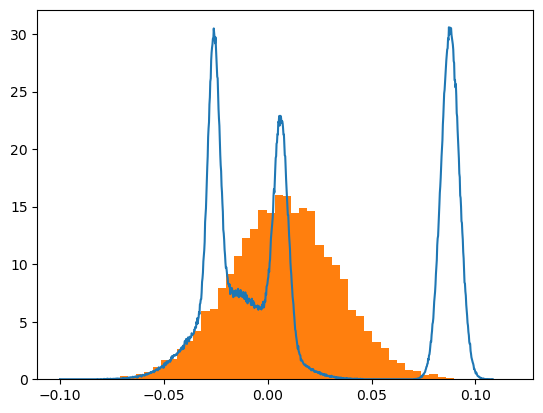

In [29]:
# true distribution
hist, bins = np.histogram(true_noise_sample, bins=1000, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist)

# predictited distribution
plt.hist(pred_pixels.reshape(-1), bins=50, density=True)
plt.show()

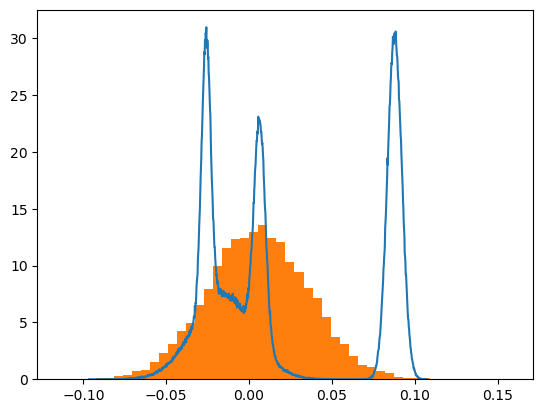

In [33]:
# true distribution
hist, bins = np.histogram(true_noise_sample, bins=1000, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist)

# predictited distribution
plt.hist(pred_pixels.reshape(-1), bins=50, density=True)
plt.show()

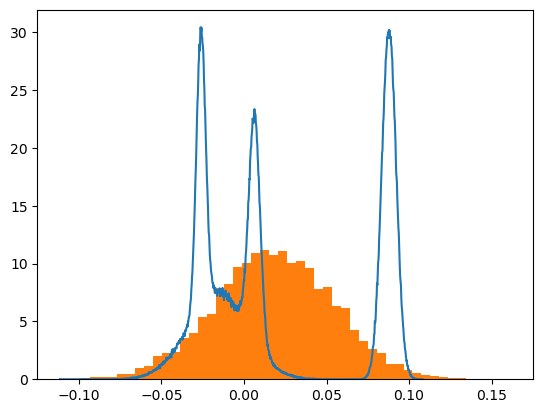

In [46]:
# true distribution
hist, bins = np.histogram(true_noise_sample, bins=1000, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist)

# predictited distribution
plt.hist(pred_pixels.reshape(-1), bins=50, density=True)
plt.show()

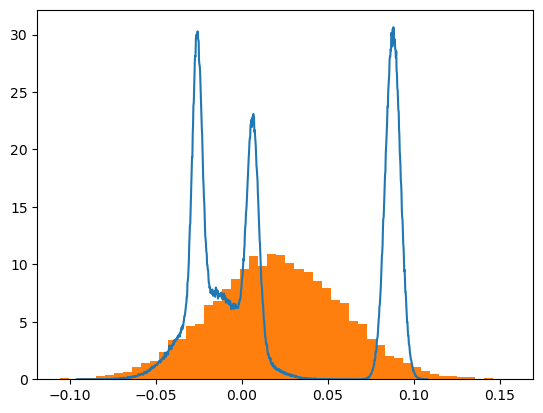

In [56]:
# true distribution
hist, bins = np.histogram(true_noise_sample, bins=1000, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist)

# predictited distribution
plt.hist(pred_pixels.reshape(-1), bins=50, density=True)
plt.show()

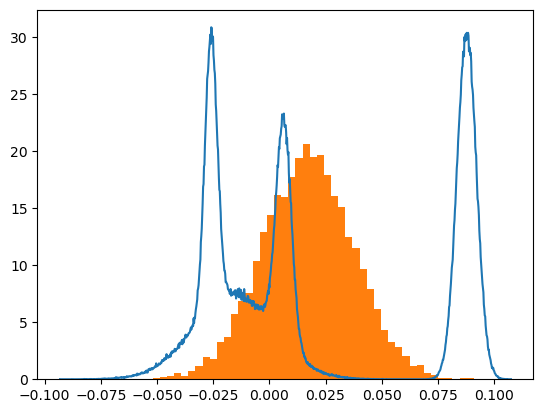

In [51]:
# true distribution
hist, bins = np.histogram(true_noise_sample, bins=1000, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, hist)

# predictited distribution
plt.hist(pred_pixels.reshape(-1), bins=50, density=True)
plt.show()

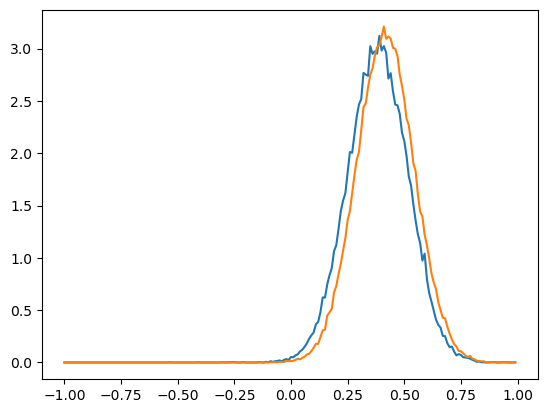

In [8]:
hist_width = 0.01

# predictited distribution
pred = pd.Series(pred_pixels.reshape(-1))
hist = pd.Series(1, index=pd.cut(pred, np.arange(-1, 1.001, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), pred_noise)

# true distribution
true = pd.Series(true_pixels.reshape(-1))
true_hist = pd.Series(1, index=pd.cut(true, np.arange(-1, 1.001, hist_width))).sort_index().groupby(level=0).sum()
true_noise = true_hist / (true_hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), true_noise)
plt.show()

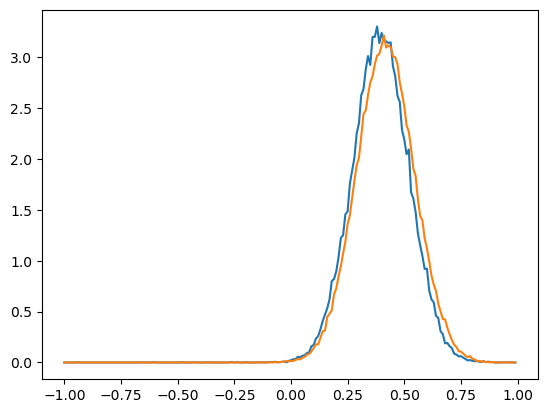

In [52]:
hist_width = 0.01

# predictited distribution
pred = pd.Series(pred_pixels.reshape(-1))
hist = pd.Series(1, index=pd.cut(pred, np.arange(-1, 1.001, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), pred_noise)

# true distribution
true = pd.Series(true_pixels.reshape(-1))
true_hist = pd.Series(1, index=pd.cut(true, np.arange(-1, 1.001, hist_width))).sort_index().groupby(level=0).sum()
true_noise = true_hist / (true_hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), true_noise)
plt.show()

In [ ]:
hist_width = 0.05

# predictited distribution
pred = pd.Series(pred_pixels.reshape(-1))
hist = pd.Series(1, index=pd.cut(pred, np.arange(-1, 1.005, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), pred_noise)

# true distribution
true = pd.Series(true_pixels.reshape(-1))
true_hist = pd.Series(1, index=pd.cut(true, np.arange(-1, 1.005, hist_width))).sort_index().groupby(level=0).sum()
true_noise = true_hist / (true_hist.sum() * hist_width)
plt.plot(np.arange(-1, 1, hist_width), true_noise)
plt.show()